# Time Series Project

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production, Jan 62 - Dec 75**

** Import Libraries **

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

** import Dataset **

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

** Check out the head of the dataframe**

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

In [4]:
milk.index = pd.to_datetime(milk.index)

** Plot out the time series data. **

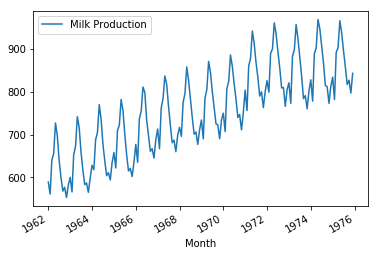

In [5]:
milk.plot()

### Train Test Split

** Let's predict 12 months or 12 steps into the future) **

In [6]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [7]:
train_set = milk.head(156)

In [8]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler.

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

## Batch Function

** Create function that can feed batches of the training data. **

In [10]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

In [11]:
import tensorflow as tf

C:\Users\Rahman\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
# Just one feature
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 200 neuron layer
num_neurons = 200
# Just one output, predicted time series
num_outputs = 1

# learning rate
learning_rate = 0.01
# 6000 iterations to go through (training steps)
num_train_iterations = 6000
# Size of the batch of data
batch_size = 1

** Create Placeholders for X and y. The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [13]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Now create the RNN Layer **

In [14]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with first placeholder (X)**

In [15]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, and pass learning rate. **

In [16]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [17]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [18]:
saver = tf.train.Saver()

### Session

** Run tf.Session that trains by the batches created by next_batch function. Also add loss function to evaluate every 100 training iterations and save model after completed training. **

In [19]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [20]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.19784312
100 	MSE: 0.008884584
200 	MSE: 0.007938932
300 	MSE: 0.006147931
400 	MSE: 0.008290359
500 	MSE: 0.008031561
600 	MSE: 0.006533003
700 	MSE: 0.0041823774
800 	MSE: 0.0075308266
900 	MSE: 0.003801081
1000 	MSE: 0.0066704773
1100 	MSE: 0.0025961974
1200 	MSE: 0.0040010693
1300 	MSE: 0.002865024
1400 	MSE: 0.002831788
1500 	MSE: 0.006859873
1600 	MSE: 0.0041779014
1700 	MSE: 0.0035734612
1800 	MSE: 0.0033277161
1900 	MSE: 0.002902347
2000 	MSE: 0.004237499
2100 	MSE: 0.0052706827
2200 	MSE: 0.005599236
2300 	MSE: 0.0021742452
2400 	MSE: 0.0033666396
2500 	MSE: 0.00504422
2600 	MSE: 0.0011728884
2700 	MSE: 0.0061311144
2800 	MSE: 0.0061921366
2900 	MSE: 0.0041153673
3000 	MSE: 0.0018211873
3100 	MSE: 0.0013403109
3200 	MSE: 0.0013822591
3300 	MSE: 0.004760139
3400 	MSE: 0.0029640852
3500 	MSE: 0.0018521984
3600 	MSE: 0.002475703
3700 	MSE: 0.0011781628
3800 	MSE: 0.0013919597
3900 	MSE: 0.0017753034
4000 	MSE: 0.0011984658
4100 	MSE: 0.0020701003
4200 	MSE: 0.002128312


## Prediction

** Last 12 months of original complete data set **

In [21]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


** Now we try to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session

In [22]:
with tf.Session() as sess:
    
    # Use Saver instance to restore rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for genreative seed from the last 12 months of the 
    # training set data.
    train_seed = list(train_scaled[-12:])
    
    ## Now create for loop 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [23]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.642858,
 0.55387473,
 0.81800854,
 0.8510968,
 1.0051377,
 0.95279163,
 0.8696044,
 0.76474327,
 0.64369607,
 0.6546953,
 0.5487578,
 0.64407885]

** Grab results that are generated and apply inverse_transform on them to turn them back into milk production value units. Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [24]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. **

In [25]:
test_set['Generated'] = results

C:\Users\Rahman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View test_set dataframe. **

In [26]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,820.428894
1975-02-01 01:00:00,782.0,783.411865
1975-03-01 01:00:00,892.0,893.291565
1975-04-01 01:00:00,903.0,907.056274
1975-05-01 01:00:00,966.0,971.137268
1975-06-01 01:00:00,937.0,949.361328
1975-07-01 01:00:00,896.0,914.755371
1975-08-01 01:00:00,858.0,871.133179
1975-09-01 01:00:00,817.0,820.777527


** Plot out the two columns for comparison. **

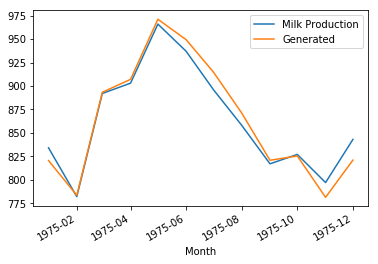

In [27]:
test_set.plot()